# Training Siamese Network

In [0]:
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [0]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    



In [0]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found
                
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [0]:
folder_dataset = dset.ImageFolder("Dataset/Train")
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

## Visualising the data, for each pair in column the label states whether the same person (0), or no (1).

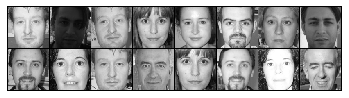

[[1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


In [0]:

vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=10,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

## Defining the model structure

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layers
        self.conv1 = nn.Conv2d(1, 4, kernel_size=3)
        self.conv2 = nn.Conv2d(4, 16, kernel_size=3)
        self.conv3 = nn.Conv2d(16, 16, kernel_size=3)

        # normalizing inputs
        self.batch1 = nn.BatchNorm2d(4)
        self.batch2 = nn.BatchNorm2d(16)
        self.batch3 = nn.BatchNorm2d(16)

        # padding 1x1
        self.padding = nn.ReflectionPad2d(1)
        
        # linear layers
        self.fc1 = nn.Linear(16 * 100 * 100, 1000)
        self.fc2 = nn.Linear(1000, 500)
        self.fc3 = nn.Linear(500,5)
        
        # dropout layer (probability = 20%)
        self.dropout = nn.Dropout(0.20)

    def first(self, x):
        # add sequence of convolutional and normalizing layers
        x = self.batch1(F.relu(self.conv1(self.padding(x))))
        x = self.batch2(F.relu(self.conv2(self.padding(x))))
        x = self.batch3(F.relu(self.conv3(self.padding(x))))

        # flatten image input
        x = x.view(-1, 16 * 100 * 100)
        # add dropout layer
        x = self.dropout(x)
        
        # add linear levels hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def forward(self, input1, input2):
        # returning outputs for both pictures
        output1 = self.babken(input1)
        output2 = self.babken(input2)
        return output1, output2




In [0]:
model = Net()
model

## Defining the loss

In [0]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

## Training Data

In [0]:
trainloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=64)

## Testing Data

In [0]:
test_dataset = dset.ImageFolder("Dataset/Test")
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=test_dataset,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

testloader = DataLoader(siamese_dataset,num_workers=6,batch_size=64,shuffle=True)

## Assigning the loss and choosing Adam optimizer

In [0]:
criterion = ContrastiveLoss()
optimizer = optim.Adam(model.parameters(),lr=0.003)

## Training for 100 epocs, printing loss and accuracy

In [0]:
epochs = 100
model.cuda()
train_loss = 0
count = []
train_loss_history = []
model.train()
for epoch in range(epochs):
    accuracy = 0
    running_loss=0
    validing_loss = 0
    for img1,img2, labels in trainloader:
        img1,img2,labels = img1.cuda(), img2.cuda(), labels.cuda()

        accuracy1 = 0
        tresh = []

        optimizer.zero_grad()
        output1,output2 = model.forward(img1,img2)
        loss = criterion(output1,output2,labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        euclidean_distance = F.pairwise_distance(output1, output2)
        for i in euclidean_distance:
            if i.item() <1:
                tresh.append([float(0)])
            else:
                tresh.append([float(1)])
        

        labels_list = labels.cpu().numpy().tolist()
        for i,j in zip(labels_list,tresh):
            if i == j:
                accuracy1+=1
      

        accuracy += accuracy1/len(labels_list)


    train_loss = running_loss/len(trainloader)
    accuracy = accuracy/len(trainloader)

    if epoch % 4 == 0:
        print('Epoch: {} \tTrain_loss: {:.3f} \tAccuracy_1: {:.3f}'.format(
            epoch, train_loss,accuracy))
    count.append(epoch)
    train_loss_history.append(train_loss)


Epoch: 0 	Train_loss: 1.067 	Accuracy_0.8: 0.710
Epoch: 4 	Train_loss: 1.199 	Accuracy_0.8: 0.613
Epoch: 8 	Train_loss: 0.402 	Accuracy_0.8: 0.855
Epoch: 12 	Train_loss: 0.219 	Accuracy_0.8: 0.952
Epoch: 16 	Train_loss: 0.176 	Accuracy_0.8: 0.968
Epoch: 20 	Train_loss: 0.118 	Accuracy_0.8: 1.000
Epoch: 24 	Train_loss: 0.095 	Accuracy_0.8: 1.000
Epoch: 28 	Train_loss: 0.082 	Accuracy_0.8: 1.000
Epoch: 32 	Train_loss: 0.116 	Accuracy_0.8: 1.000
Epoch: 36 	Train_loss: 0.070 	Accuracy_0.8: 1.000
Epoch: 40 	Train_loss: 0.056 	Accuracy_0.8: 0.984
Epoch: 44 	Train_loss: 0.082 	Accuracy_0.8: 1.000
Epoch: 48 	Train_loss: 0.076 	Accuracy_0.8: 1.000
Epoch: 52 	Train_loss: 0.050 	Accuracy_0.8: 0.984
Epoch: 56 	Train_loss: 0.035 	Accuracy_0.8: 1.000
Epoch: 60 	Train_loss: 0.035 	Accuracy_0.8: 1.000
Epoch: 64 	Train_loss: 0.024 	Accuracy_0.8: 1.000
Epoch: 68 	Train_loss: 0.316 	Accuracy_0.8: 0.952
Epoch: 72 	Train_loss: 0.043 	Accuracy_0.8: 1.000
Epoch: 76 	Train_loss: 0.028 	Accuracy_0.8: 1.000
Epo

## Plotting the loss

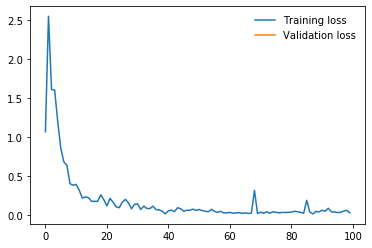

In [0]:
plt.plot(train_loss_history, label='Training loss')
plt.legend(frameon=False)

## Testing the model on test set

In [0]:
test_loss = 0
model.cuda()
model.eval()
accuracy = 0 
num = 0
for img1,img2, labels in testloader:
    num+=1
    tresh = []
    running_loss = 0
    accuracy1 = 0
    img1,img2,labels = img1.cuda(), img2.cuda(), labels.cuda()
    with torch.no_grad():
        output1,output2 = model(img1,img2)

    loss = criterion(output1,output2,labels)
    running_loss += loss.item()

    euclidean_distance = F.pairwise_distance(output1, output2)
    for i in euclidean_distance:
        if i <1:
            tresh.append([float(0)])
        else:
            tresh.append([float(1)])
    labels_list = labels.cpu().numpy().tolist()
    for i,j in zip(tresh, labels_list):
        #print(i,j)
        if i == j:
            accuracy1+=1
    
    accuracy +=accuracy1/len(labels_list) 


test_loss = running_loss

print("Test loss {:.2f} \tAccuracy {:.5f}".format(test_loss,accuracy))
    

    

Test loss 0.03 	Accuracy 1.00000


## Visualising the results

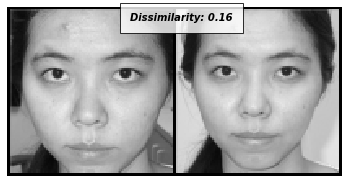

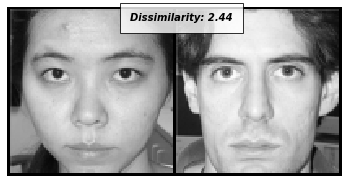

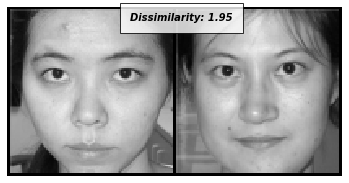

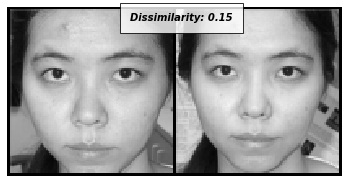

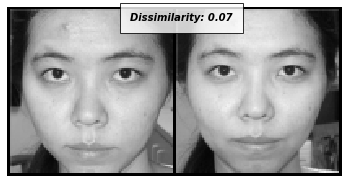

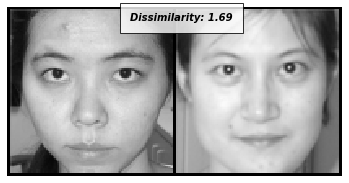

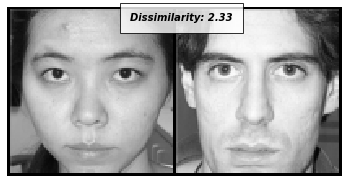

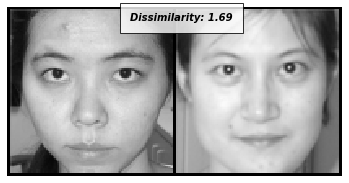

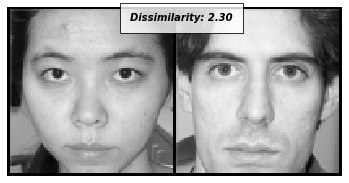

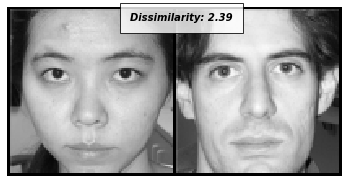

In [0]:
testloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(testloader)
x0,_,_ = next(dataiter)

for i in range(10):
    _,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    
    output1,output2 = model(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))